## 1. Configurations
----

In [1]:
!pip install xgboost

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

pd.set_option('display.max_columns',None) # exibir todas as colunas do meu df
pd.set_option("display.max_seq_items", None) # exibir todas as linhas no meu for


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


## 2. Dataset
----

In [2]:
# data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv'
# !wget $data

In [3]:
df = pd.read_csv('CreditScoring.csv')

## 3. Data Cleaning and Preparation
----

In [4]:
df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [5]:
df.columns = df.columns.str.lower().str.strip()

In [6]:
# Informations of Categorical Variables

status_values = {
    1 : 'ok', 
    2:'default', 
    0: 'unknown'
}

home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unknown'
}

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unknown'
}

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unknown'
}

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unknown'
}

df['status'] = df['status'].map(status_values)
df['home'] = df['home'].map(home_values)
df['marital'] = df['marital'].map(marital_values)
df['records'] = df['records'].map(records_values)
df['job'] = df['job'].map(job_values)

In [7]:
df.describe().round()

# We have 99999999.0 in columns income, assets and debt, meaning that is a missing value.
# We will need to do something with it.

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


In [8]:
columns = ['income', 'assets', 'debt']
for c in columns:
    df[c] = df[c].replace(to_replace=99999999, value=np.nan)

In [9]:
df = df[df['status'] != 'unknown'].reset_index(drop=True)

In [10]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

In [11]:
df_full_train = df_full_train.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [12]:
y_full_train = (df_full_train['status'] == 'default').astype('int').values
y_train = (df_train['status'] == 'default').astype('int').values
y_val = (df_val['status'] == 'default').astype('int').values
y_test = (df_test['status'] == 'default').astype('int').values

In [13]:
del df_full_train['status']
del df_train['status']
del df_val['status']
del df_test['status']

## 4.  Decision Trees
----

In [14]:
train_dicts = df_train.fillna(0).to_dict(orient='records')

In [15]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [16]:
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [17]:
val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [18]:
y_pred = dt.predict_proba(X_val)[:,1]

In [19]:
roc_auc_score(y_val, y_pred)

0.7389079944782155

In [20]:
print(export_text(dt, feature_names=dv.get_feature_names_out()))

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- amount <= 862.50
|   |   |   |--- class: 0
|   |   |--- amount >  862.50
|   |   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- income <= 103.50
|   |   |   |--- class: 1
|   |   |--- income >  103.50
|   |   |   |--- class: 0
|--- records=no >  0.50
|   |--- job=partime <= 0.50
|   |   |--- income <= 74.50
|   |   |   |--- class: 0
|   |   |--- income >  74.50
|   |   |   |--- class: 0
|   |--- job=partime >  0.50
|   |   |--- assets <= 8750.00
|   |   |   |--- class: 1
|   |   |--- assets >  8750.00
|   |   |   |--- class: 0



## 5. Decision Tree: parameter tuning
----

In [21]:
max_depth_values = [1, 2, 3, 4, 5, 6, 10, 15, 20, None]

for d in max_depth_values:
    dt = DecisionTreeClassifier(max_depth=d)
    dt.fit(X_train, y_train)

    y_pred = dt.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, y_pred)

    print(f"max_depth: {d} | auc: {auc:.3f}")

max_depth: 1 | auc: 0.606
max_depth: 2 | auc: 0.669
max_depth: 3 | auc: 0.739
max_depth: 4 | auc: 0.761
max_depth: 5 | auc: 0.767
max_depth: 6 | auc: 0.760
max_depth: 10 | auc: 0.716
max_depth: 15 | auc: 0.661
max_depth: 20 | auc: 0.654


max_depth: None | auc: 0.665


In [22]:
max_depth_values = [4, 5, 6]
min_samples_leaf_values = [1, 2, 5, 10, 15, 20, 100, 200, 500]
scores = []

for d in max_depth_values:
    print(f"max_depth: {d}")
    for s in min_samples_leaf_values:
        dt = DecisionTreeClassifier(max_depth=d, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val, y_pred)

        print(f"  -> min_samples_leaf: {s} | auc: {auc:.3f}")

        scores.append((d, s, auc))

max_depth: 4
  -> min_samples_leaf: 1 | auc: 0.761
  -> min_samples_leaf: 2 | auc: 0.761
  -> min_samples_leaf: 5 | auc: 0.761
  -> min_samples_leaf: 10 | auc: 0.761
  -> min_samples_leaf: 15 | auc: 0.764
  -> min_samples_leaf: 20 | auc: 0.761
  -> min_samples_leaf: 100 | auc: 0.756
  -> min_samples_leaf: 200 | auc: 0.747
  -> min_samples_leaf: 500 | auc: 0.680
max_depth: 5
  -> min_samples_leaf: 1 | auc: 0.766
  -> min_samples_leaf: 2 | auc: 0.766
  -> min_samples_leaf: 5 | auc: 0.768
  -> min_samples_leaf: 10 | auc: 0.762
  -> min_samples_leaf: 15 | auc: 0.773
  -> min_samples_leaf: 20 | auc: 0.774
  -> min_samples_leaf: 100 | auc: 0.763
  -> min_samples_leaf: 200 | auc: 0.759
  -> min_samples_leaf: 500 | auc: 0.680
max_depth: 6
  -> min_samples_leaf: 1 | auc: 0.759
  -> min_samples_leaf: 2 | auc: 0.763
  -> min_samples_leaf: 5 | auc: 0.762
  -> min_samples_leaf: 10 | auc: 0.778
  -> min_samples_leaf: 15 | auc: 0.785
  -> min_samples_leaf: 20 | auc: 0.774
  -> min_samples_leaf: 100 |

In [23]:
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns = columns)

In [24]:
df_scores.sort_values(by='auc',ascending=False).head()

,max_depth,min_samples_leaf,auc
22,6,15,0.785471
21,6,10,0.777521
24,6,100,0.776434
23,6,20,0.774279
14,5,20,0.774028


In [25]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf',
                                  columns=['max_depth'],
                                  values=['auc']
                                 )
df_scores_pivot.round(3)

auc              
max_depth             4      5      6
min_samples_leaf                     
1                 0.761  0.766  0.759
2                 0.761  0.766  0.763
5                 0.761  0.768  0.762
10                0.761  0.762  0.778
15                0.764  0.773  0.785
20                0.761  0.774  0.774
100               0.756  0.763  0.776
200               0.747  0.759  0.768
500               0.680  0.680  0.680

<Axes: xlabel='None-max_depth', ylabel='min_samples_leaf'>

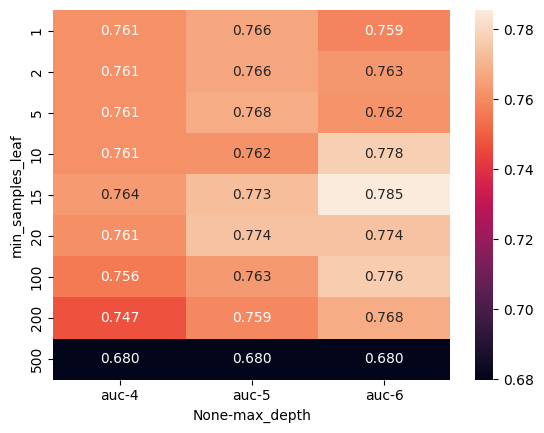

In [26]:
sns.heatmap(df_scores_pivot, annot=True, fmt='.3f')

In [27]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,6
,min_samples_split,2
,min_samples_leaf,15
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


## 6. Random Forest
----

In [28]:
rf = RandomForestClassifier(n_estimators=10, random_state=1)
rf.fit(X_train, y_train)

,n_estimators,10
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [29]:
y_pred = rf.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred)

0.7744726453706618

In [30]:
scores = []
x = []

for n in range(10,201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, y_pred)

    print(f'n_estimators = {n} | auc = {auc:.3f}')
    scores.append(auc)
    x.append(n)

n_estimators = 10 | auc = 0.774
n_estimators = 20 | auc = 0.804
n_estimators = 30 | auc = 0.815
n_estimators = 40 | auc = 0.816
n_estimators = 50 | auc = 0.817
n_estimators = 60 | auc = 0.816
n_estimators = 70 | auc = 0.817
n_estimators = 80 | auc = 0.816
n_estimators = 90 | auc = 0.817
n_estimators = 100 | auc = 0.818
n_estimators = 110 | auc = 0.818
n_estimators = 120 | auc = 0.818
n_estimators = 130 | auc = 0.818
n_estimators = 140 | auc = 0.818
n_estimators = 150 | auc = 0.817
n_estimators = 160 | auc = 0.818
n_estimators = 170 | auc = 0.818
n_estimators = 180 | auc = 0.817
n_estimators = 190 | auc = 0.818
n_estimators = 200 | auc = 0.819


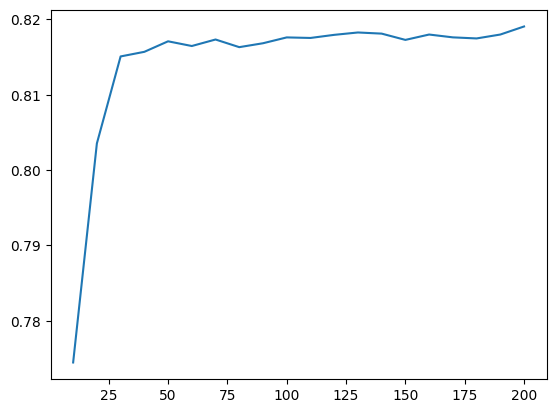

In [31]:
plt.plot(x, scores)

In [32]:
scores = []
x = []
max_depth_values = [5, 10, 15]

for d in max_depth_values:
    for n in range(10,201, 10):
        rf = RandomForestClassifier(n_estimators=n, random_state=1, max_depth=d)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, n, auc))
        x.append(n)

In [33]:
columns = ['max_depth', 'n_estimators', 'auc']

df_scores = pd.DataFrame(scores, columns=columns)
df_scores.head()

,max_depth,n_estimators,auc
0,5,10,0.787699
1,5,20,0.797731
2,5,30,0.800305
3,5,40,0.799708
4,5,50,0.799878


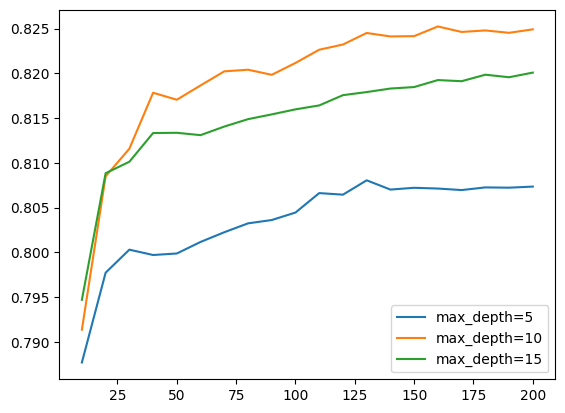

In [34]:
for d in max_depth_values:
    df_subset = df_scores[df_scores['max_depth'] == d]
    plt.plot(df_subset['n_estimators'], df_subset['auc'], label=f'max_depth={d}')

plt.legend()

In [35]:
max_depth=10

In [36]:
min_samples_leaf_values = [1, 3, 5, 10, 50]
scores = []

for s in min_samples_leaf_values:
    for n in range(10,201, 10):
        rf = RandomForestClassifier(n_estimators=n, 
                                    random_state=1, 
                                    max_depth=max_depth,
                                    min_samples_leaf=s)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((s, n, auc))

In [37]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']

df_scores = pd.DataFrame(scores, columns=columns)
df_scores

,min_samples_leaf,n_estimators,auc
0,1,10,0.791365
1,1,20,0.808496
2,1,30,0.811584
3,1,40,0.817839
4,1,50,0.817058
...,...,...,...
95,50,160,0.805929
96,50,170,0.805172
97,50,180,0.805324
98,50,190,0.805596


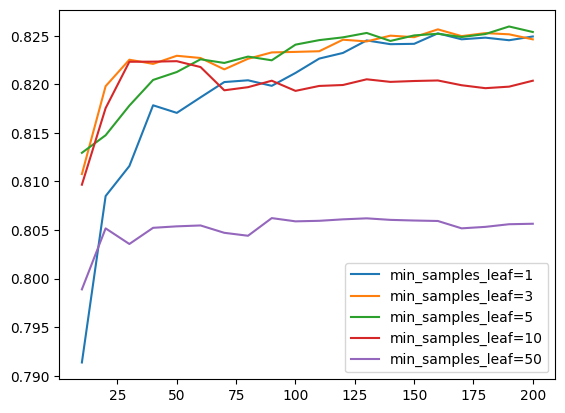

In [38]:
for s in min_samples_leaf_values:
    df_subset = df_scores[df_scores['min_samples_leaf'] == s]
    plt.plot(df_subset['n_estimators'], df_subset['auc'], label=f'min_samples_leaf={s}')

plt.legend()

In [39]:
min_samples_leaf=3

In [40]:
rf = RandomForestClassifier(n_estimators=100, 
                            random_state=1, 
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf)
rf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,3
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## 7. Gradient Boosting and XGBoost
----

In [41]:
features = list(dv.get_feature_names_out())

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval   = xgb.DMatrix(X_val,   label=y_val,   feature_names=features)

In [42]:
watchlist = [(dtrain, 'train'), (dval, 'validation')]

In [43]:
%%capture output

xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params,
                  dtrain,
                  evals=watchlist,
                  verbose_eval=5,
                  num_boost_round=200
                )

In [44]:
def parse_xgb_outpub(output):
    results = []
    tree = []
    aucs_train = []
    aucs_val = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))

    columns = ['num_iter','train_auc','val_auc' ]
    df_results = pd.DataFrame(results, columns=columns)

    return df_results

In [45]:
df_score = parse_xgb_outpub(output)

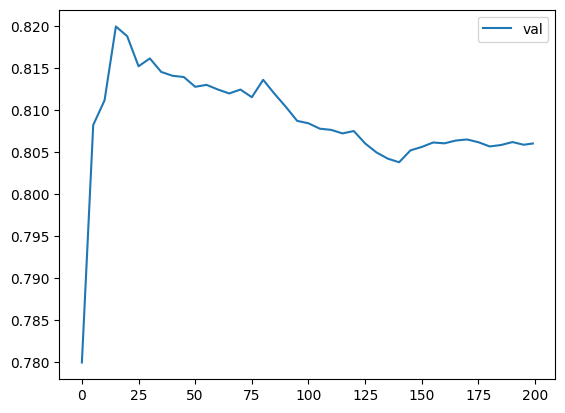

In [46]:
# plt.plot(df_score['num_iter'],df_score['train_auc'], label='train')
plt.plot(df_score['num_iter'],df_score['val_auc'], label='val')
plt.legend()

## 8. Tuning XGBoost parameters
----

In [47]:
scores = {}

In [48]:
%%capture output

xgb_params = {
    'eta': 0.01,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params,
                  dtrain,
                  evals=watchlist,
                  verbose_eval=5,
                  num_boost_round=200
                )

In [49]:
key = f'eta={xgb_params['eta']}'
scores[key] = parse_xgb_outpub(output)

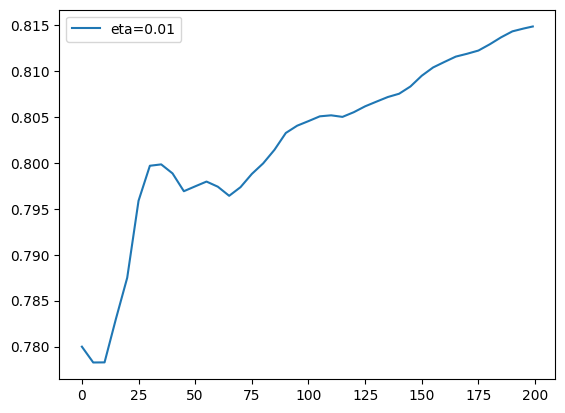

In [50]:
for key, df_score in scores.items():
    plt.plot(df_score['num_iter'],df_score['val_auc'], label=key)
plt.legend()

In [51]:
scores = {}

In [52]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 10,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params,
                  dtrain,
                  evals=watchlist,
                  verbose_eval=5,
                  num_boost_round=200
                )

In [53]:
key = f'max_depth={xgb_params['max_depth']}'
scores[key] = parse_xgb_outpub(output)

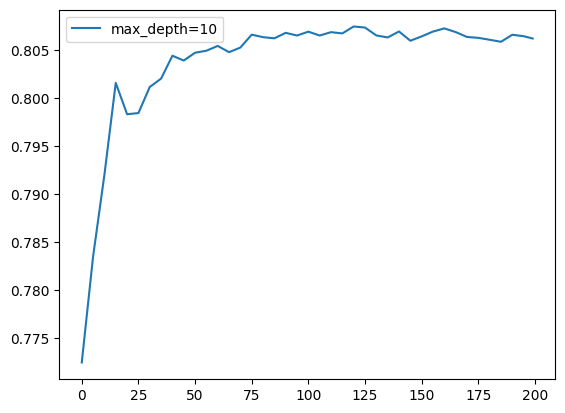

In [54]:
for key, df_score in scores.items():
    plt.plot(df_score['num_iter'],df_score['val_auc'], label=key)
plt.legend()

In [55]:
scores = {}

In [56]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 30,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params,
                  dtrain,
                  evals=watchlist,
                  verbose_eval=5,
                  num_boost_round=200
                )

In [57]:
key = f'min_child_weight={xgb_params['min_child_weight']}'
scores[key] = parse_xgb_outpub(output)

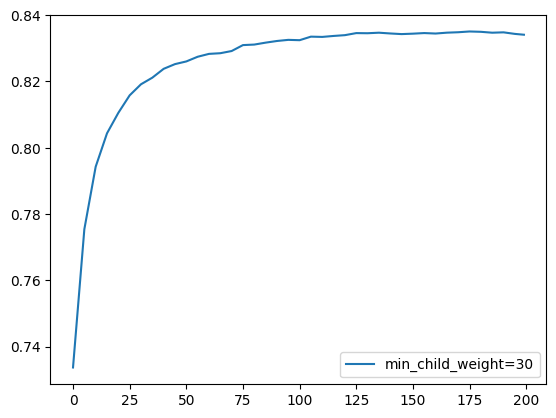

In [58]:
for key, df_score in scores.items():
    plt.plot(df_score['num_iter'],df_score['val_auc'], label=key)
plt.legend()

In [59]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params,
                  dtrain,
                  num_boost_round=175
                )

## 9. Selecting the best model
----

In [60]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,6
,min_samples_split,2
,min_samples_leaf,15
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [63]:
y_pred = dt.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred)

0.7853194400716863

In [61]:
rf = RandomForestClassifier(n_estimators=200, 
                            random_state=1, 
                            max_depth=10,
                            min_samples_leaf=3)
rf.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,3
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [64]:
y_pred = rf.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred)

0.8246258264512848

In [62]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params,
                  dtrain,
                  num_boost_round=175
                )

In [66]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.8334715797631446

In [ ]:
dicts_full_train = df_full_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)

X_full_train = dv.fit_transform(dicts_full_train)

dicts_test = df_test.to_dict(orient='records')
X_test = dv.transform(dicts_test)

features = list(dv.get_feature_names_out())

dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train, feature_names=features)
dtest = xgb.DMatrix(X_test, feature_names=features)


In [86]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params,
                  dfulltrain,
                  num_boost_round=175
                )

In [88]:
y_pred = model.predict(dtest)
roc_auc_score(y_test, y_pred)

0.8299814280826938